Copyright (c) 2021-2024, NVIDIA CORPORATION & AFFILIATES

SPDX-License-Identifier: BSD-3-Clause

In this notebook, we use a simple example to show how to use `cuquantum.CircuitToEinsum` 
to take a `qiskit.QuantumCircuit` instance and run basic quantum circuit simulation using cuTensorNet.

In [1]:
import itertools

import cupy as cp
import numpy as np
import qiskit
from qiskit.circuit.random import random_circuit

from cuquantum import contract
from cuquantum import CircuitToEinsum

## Generate a random quantum circuit

The generated `circuit` object is of type `qiskit.QuantumCircuit`.

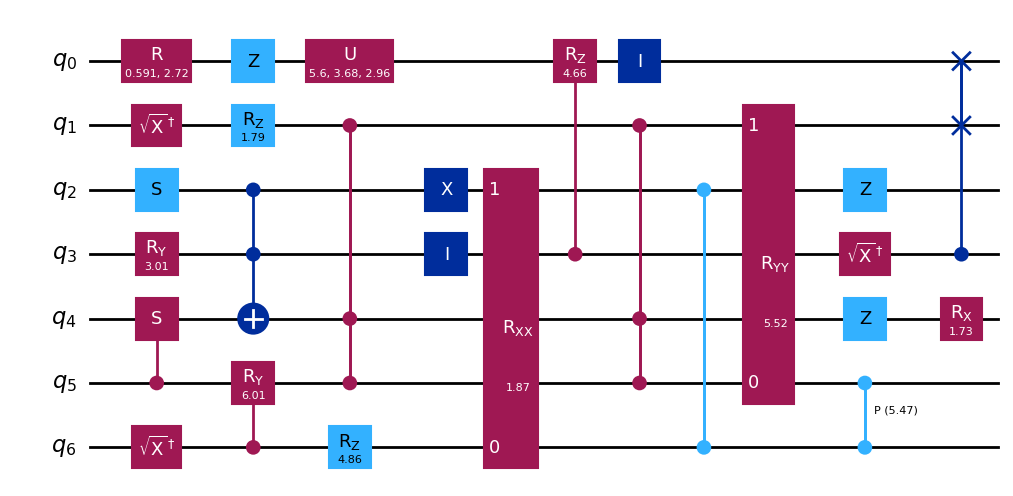

In [2]:
num_qubits = 7
depth = 6

circuit = random_circuit(num_qubits, depth, seed=3)
circuit.draw(output='mpl')

## Construct the converter object targeting double precision

In this example, we generate the tensor operands as CuPy arrays (by setting `backend=cupy`).

In [3]:
myconverter = CircuitToEinsum(circuit, dtype='complex128', backend=cp)

### compute state vector $| \psi\rangle$

Different from the notation in `qiskit`, the indices of the output tensor is consistent with `qiskit.QuantumCircuit.qubits`

In [4]:
expression, operands = myconverter.state_vector()
sv = contract(expression, *operands)
print(f'wavefunction coefficient shape: {sv.shape}')

# check if the computed statevector is correct
try:
    # qiskit 1.0
    from qiskit_aer import AerSimulator
    simulator = AerSimulator()
except ImportError:
    simulator = qiskit.Aer.get_backend('aer_simulator_statevector')

circuit.save_statevector()
circ = qiskit.transpile(circuit, simulator)
result = simulator.run(circ).result()
sv_qiskit = cp.asarray(result.get_statevector()).reshape([2]*num_qubits)
sv_qiskit = sv_qiskit.transpose(range(num_qubits-1, -1, -1))

print(abs(sv-sv_qiskit).sum())
print(f"is sv in agreement?", cp.allclose(sv, sv_qiskit))

wavefunction coefficient shape: (2, 2, 2, 2, 2, 2, 2)
1.5083850350595167e-14
is sv in agreement? True


### calculate bitstring amplitude $\langle b| \psi\rangle$

In [5]:
bitstring = '0000000'

expression, operands = myconverter.amplitude(bitstring)
print(f'einsum expression:\n{expression} \n')

amplitude = contract(expression, *operands)
probability = abs(amplitude) ** 2
print(f'for bitstring {bitstring}, amplitude: {amplitude}, probability: {probability}\n')

amplitude_from_sv = sv[0,0,0,0,0,0,0]
amp_diff = abs(amplitude-amplitude_from_sv)
print(f'difference from state vector {amp_diff}')

einsum expression:
a,b,c,d,e,f,g,ha,ih,ji,kj,lb,ml,nm,on,pc,qd,rf,ster,us,vwut,xv,yx,zAyp,Bz,CDBq,EC,FGEA,HF,IJHD,KG,LI,ML,NOKJ,PO,QN,RSQP,TR,US,VWkU,XV,YW,ZY,ÀZ,Ág,ÂÁ,ÃÂ,ÄÅwÃ,Æo,ÇÆ,ÈÉÇÄ,ÊÈ,ËÌÊM,ÍË,ÎÏÍÉ,ÐÎ,ÑÒÐÌ,ÓÏ,ÔÑ,ÕÔ,Ö×ÓÒ,Ø×,ÙÖ,ÚÛÙØ,ÜÕ,ÝÛ,ÞÝ,ßàÞÚ,áß,âãáÜ,äâ,åæäà,çå,èéçã,êæ,ëè,ìë,íîêé,ïî,ðí,ñòðï,óì,ôó,õô,ö÷òñ,øùöX,úù,ûüúø,ýû,þÿýÀ,Āþ,āĂĀü,ăā,Ąąăÿ,ĆĂ,ćĄ,Ĉć,ĉĊĆą,ċĊ,Čĉ,čĎČċ,ďĐčĈ,đÅ,ĒēTđ,Ĕē,ĕĖĔĒ,ėĕ,ĘĖ,ęĚė÷,Đ,ď,Ę,Ď,õ,Ě,ę-> 

for bitstring 0000000, amplitude: (-0.011226507839517978+0.1725149355570933j), probability: 0.029887437468538815

difference from state vector 2.949029909160572e-17


### calculate batch of bistring amplitudes

In this example, we calculate a batch of bistring amplitudes $\langle 00000ij|\psi\rangle$ where the first 5 qubits are fixed at state $00000$ and the last two qubit states are batched. This is equivalent to computing a slice of the full state vector.

In [6]:
fixed_states = '00000'
fixed_index = tuple(map(int, fixed_states))
num_fixed = len(fixed_states)

# mapping of the first 5 qubits to the fixed state
fixed = dict(zip(myconverter.qubits[:num_fixed], fixed_states))

expression, operands = myconverter.batched_amplitudes(fixed)
batched_amplitudes = contract(expression, *operands)

for ibit, jbit in itertools.product(range(2), repeat=2):
    bitstring = fixed_states + str(ibit) + str(jbit)
    index = fixed_index + (ibit, jbit)
    amplitude = batched_amplitudes[(ibit, jbit)]
    amplitude_from_sv = sv[index]
    amp_diff = abs(amplitude-amplitude_from_sv)
    print(f'for bitstring {bitstring}, amplitude: {amplitude:.4f}, difference from state vector: {amp_diff:.4f}')

for bitstring 0000000, amplitude: -0.0112+0.1725j, difference from state vector: 0.0000
for bitstring 0000001, amplitude: -0.0048-0.1722j, difference from state vector: 0.0000
for bitstring 0000010, amplitude: 0.0675-0.0010j, difference from state vector: 0.0000
for bitstring 0000011, amplitude: -0.0562+0.0403j, difference from state vector: 0.0000


### compute expectation value $\langle \psi|\hat{O}| \psi\rangle$

In this example, we compute the expectation value for a pauli string $IXXZZII$. For comparision, we compute the same value via contracting reduced density matrix with the operator.

In [7]:
pauli_string = 'IXXZZII'
expression, operands = myconverter.expectation(pauli_string, lightcone=True)
expec = contract(expression, *operands)
print(f'expectation value for {pauli_string}: {expec}')

# expectation value from reduced density matrix
qubits = myconverter.qubits
where = qubits[1:5]
rdm_expression, rdm_operands = myconverter.reduced_density_matrix(where, lightcone=True)
rdm = contract(rdm_expression, *rdm_operands)

pauli_x = cp.asarray([[0,1],[1,0]], dtype=myconverter.dtype)
pauli_z = cp.asarray([[1,0],[0,-1]], dtype=myconverter.dtype)
expec_from_rdm = cp.einsum('abcdABCD,aA,bB,cC,dD->', rdm, pauli_x, pauli_x, pauli_z, pauli_z)

print(f"is expectation value in agreement?", cp.allclose(expec, expec_from_rdm))

expectation value for IXXZZII: (0.00532977992503183+1.417236088263614e-17j)
is expectation value in agreement? True


### compute reduced density matrix $\rho\left( {\bar{p}|b_{\bar{f}}} \right) = Tr_{\bar{p}}\langle b_{\bar{f}}|\psi_{\bar{f}\cup\bar{p}}\rangle \langle \psi_{\bar{f}\cup\bar{p}}\rangle| b_{\bar{f}} \rangle$

In this example, we construct the reduced density matrix of qubits 0 & 1 (so the returned RDM should have $2^2\times2^2=16$ elements), with qubits 3 & 4 fixed at state 0

In [8]:
where = circuit.qubits[:2]
fixed = {circuit.qubits[3]: '0',
         circuit.qubits[4]: '0'}

# we set lightcone=True to reduce the size of the tensor network
expression, operands = myconverter.reduced_density_matrix(where, fixed=fixed, lightcone=True)
rdm = contract(expression, *operands)
print(f'shape of reduced density matrix: {rdm.shape}')

# check if the computed RDM is correct
rdm_from_sv = contract('abefg, ABefg->abAB', sv[:, :, :, 0, 0], sv[:, :, :, 0, 0].conj())
print(f"is rdm in agreement?", cp.allclose(rdm, rdm_from_sv))

shape of reduced density matrix: (2, 2, 2, 2)
is rdm in agreement? True
